# Question 2.2, SVD

In [39]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import TruncatedSVD
import os, os.path
from PIL import Image
from scipy.sparse import lil_matrix,linalg
from scipy.stats import truncnorm
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [2]:
size_tup = (256,256)
count = 0
imageNameArr = []
categoryArr = []
sizeArr = []
grayImageArr = []
cumSizeArr = []
indArr = []
animalPath = 'Data/Animal'
fungusPath = 'Data/Fungus'
geoPath = 'Data/Geological Formation'
personPath = 'Data/Person'
plantPath = 'Data/Plant, flora, plant life'
sportPath = 'Data/Sport'

# animal:0, fungus:1, geo:2, person:3, plant:4, sport:5
categoryArr = [animalPath, fungusPath, geoPath, personPath, plantPath, sportPath]
totalSize = 0

for category in categoryArr:
    fold_size = len([name for name in os.listdir(category)])
    sizeArr.append(fold_size)
    totalSize += fold_size
    cumSizeArr.append(totalSize)
    
single_mat = np.empty([totalSize, size_tup[0]*size_tup[1]*3])
ind = 0

for a,category in enumerate(categoryArr):
    dirList = os.listdir(category)

    for i,fname in enumerate(dirList):
        img = Image.open(category+'/'+fname)
        img = img.resize(size_tup)
        np_img = np.asarray(img)
        shape_tup = np_img.shape
        imageNameArr.append(fname)

        r_img = np.empty([size_tup[0],size_tup[1]])
        g_img = np.empty([size_tup[0],size_tup[1]])
        b_img = np.empty([size_tup[0],size_tup[1]])

        # check if image is grayscale
        if len(shape_tup) < 3:
            r_img = np_img
            g_img = np_img
            b_img = np_img
            grayImageArr.append(np_img)
            count += 1
        else:
            # iterate through img and store r,g,b
            for color in range(shape_tup[len(shape_tup)-1]):
                if color == 0:
                    r_img = np_img[:,:,color]
                elif color == 1:
                    g_img = np_img[:,:,color]
                else:
                    b_img = np_img[:,:,color]

        r_vect = np.transpose(r_img).flatten()
        g_vect = np.transpose(g_img).flatten()
        b_vect = np.transpose(b_img).flatten()
        temp_vect = np.empty([3, size_tup[0]*size_tup[1]])
        temp_vect[0] = r_vect
        temp_vect[1] = g_vect
        temp_vect[2] = b_vect
        new_vect = temp_vect.flatten()
        single_mat[ind] = new_vect
        indArr.append(ind)
        ind += 1

In [3]:
print single_mat.shape

(8987, 196608)


In [4]:
svd = TruncatedSVD(n_components=256)
new_mat = svd.fit_transform(single_mat)

In [5]:
print new_mat.shape

(8987, 256)


# Question 3
User Image Matrix

In [83]:
users = [x for x in range(1000)]
u_c_mat = lil_matrix((len(users), totalSize), dtype=np.float64)
img_ind = 0
mean_arr = []

for arr in categoryArr:
    cat_mean = np.random.uniform(1.5,4.5)
    mean_arr.append(cat_mean)
    
for user in users:
    catChoiceArr = list(np.random.choice(6,4,replace=False))
    catChoiceArr.sort()
    choiceInd = 0
    for catInd,catPath in enumerate(categoryArr):
        if choiceInd >= 4:
            break
        if catChoiceArr[choiceInd] == catInd:
            if catInd == 0:
                img_ind = 0
            else:
                img_ind = cumSizeArr[catInd-1]
#             cat_mean = np.random.uniform(1.5,4.5)
            m = np.random.geometric(p=0.1,size=1)%sizeArr[catInd] 
            img_indices = list(np.random.choice(sizeArr[catInd],m,replace=False))
            for i,movie_ind in enumerate(img_indices):
                ind_val = img_ind + movie_ind
                rating = truncnorm.rvs(a=(1-mean_arr[catInd])/1,b=(5-mean_arr[catInd])/1,loc=mean_arr[catInd],scale=1)
                u_c_mat[user,ind_val] = rating
            choiceInd += 1
    

Using svd on dense matrix here would yield poor results (accuracy=13%). Hence, no need to convert this sparse matrix into dense matrix.

In [84]:
u,s,v = linalg.svds(u_c_mat)

In [85]:
print u.shape, s.shape, v.shape

(1000, 6) (6,) (6, 8987)


# Question 4

In [86]:
def get_euc_mat(mat):
    y = pdist(mat, metric='euclidean')
    euc_mat = squareform(y)
    return euc_mat

In [87]:
def get_image_category(imageID):
#     animal:0, fungus:1, geo:2, person:3, plant:4, sport:5
    cat_val = -1
    if imageID >= cumSizeArr[len(cumSizeArr)-1]:
        return cat_val
    
    for i,val in enumerate(cumSizeArr):
        if imageID < val:
            cat_val = i
            break
            
    return cat_val+1

In [88]:
def get_neighbours(mat):
    nn_arr = []
    category_arr = []
    for row_id in range(mat.shape[0]):
        temp_arr = mat[row_id]
        id_arr = np.argsort(temp_arr)
        temp_nn = []
        temp_cat = []
        for i,img_id in enumerate(id_arr):
            if i>=1 and i<=5:
                temp_nn.append(img_id)
                temp_cat.append(get_image_category(img_id))
            elif i>5:
                break
        nn_arr.append(temp_nn)
        category_arr.append(temp_cat)
    return category_arr

In [105]:
def get_reverse_neighbours(mat):
    nn_arr = []
    category_arr = []
    for row_id in range(mat.shape[0]):
        temp_arr = mat[row_id]
        id_arr = np.argsort(temp_arr)[::-1]
        temp_nn = []
        temp_cat = []
        for i,img_id in enumerate(id_arr):
            if i>=0 and i<=4:
                temp_nn.append(img_id)
                temp_cat.append(get_image_category(img_id))
            elif i>=5:
                break
        nn_arr.append(temp_nn)
        category_arr.append(temp_cat)
    return category_arr

In [90]:
def get_true_arr():
    true_arr = []
    for i in range(totalSize):
        true_arr.append(get_image_category(i))
    
    return true_arr

In [91]:
def get_pred_arr(category_arr):
    pred = []
    
    for arr in category_arr:
        a = np.array(arr)
        count = np.bincount(a)
        pred.append(np.argmax(count))
    
    return pred

In [92]:
def get_confusion_matrix(pred_arr):
    cm = confusion_matrix(true_arr, pred_arr, labels=[1,2,3,4,5,6])
    return cm

In [93]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(categoryArr))
    plt.xticks(tick_marks, ["Animal","Fungus","Geo","Person","Plant","Sport"], rotation=45)
    plt.yticks(tick_marks, ["Animal","Fungus","Geo","Person","Plant","Sport"])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [94]:
def convert_category_string_to_int(category):
    cat_int = -1
    
    if category == "Animal":
        cat_int = 1
    elif category == "Fungus":
        cat_int = 2
    elif category == "Geo":
        cat_int = 3
    elif category == "Person":
        cat_int = 4
    elif category == "Plant":
        cat_int = 5
    elif category == "Sport":
        cat_int = 6
        
    return cat_int

In [95]:
def convert_category_arr_to_int(nn_arr):
    cat_arr = []
    for arr in nn_arr:
        temp = []
        for str_val in arr:
            category = convert_category_string_to_int(str_val)
            temp.append(category)
        cat_arr.append(temp)
    
    return cat_arr

In [18]:
# getTrueValues
true_arr = get_true_arr()

# SVD - Euclidean

In [19]:
# getPredValues
euc_mat = get_euc_mat(new_mat)
nn_arr = get_neighbours(euc_mat)
pred_arr = get_pred_arr(nn_arr)
cm = get_confusion_matrix(pred_arr)
print cm

[[ 476  195  390   66  226  218]
 [ 206  491  188   31  197   94]
 [ 177  105 1257   36   95  138]
 [ 277  179  314  215   93  164]
 [ 184  207  206   29  567   78]
 [ 330  127  540   43  186  662]]


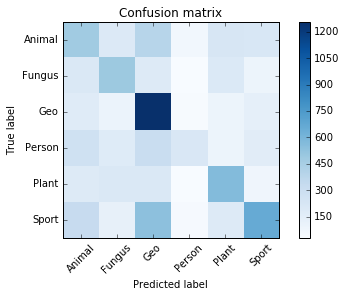

In [20]:
plt.figure()
plot_confusion_matrix(cm)

In [21]:
accuracy = (np.array(true_arr) == np.array(pred_arr)).sum() / float(len(true_arr))
print accuracy

0.408145098476


# User-Image Rating Matrix - Euclidean

In [96]:
# getPredValues
v_tran = np.transpose(v)
euc_mat = get_euc_mat(v_tran)
nn_arr = get_neighbours(euc_mat)
pred_arr = get_pred_arr(nn_arr)
cm = get_confusion_matrix(pred_arr)
print cm

[[1014   80  178   23  106  170]
 [  73  846   95   36   53  104]
 [ 207  129  736  123  158  455]
 [  28   60  172  810   82   90]
 [ 155   99  267  102  421  227]
 [ 180  135  493   86  247  747]]


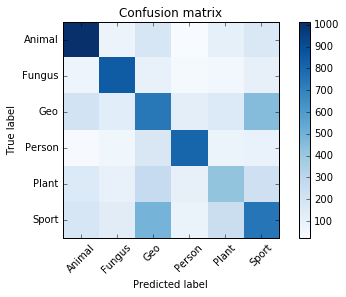

In [97]:
plt.figure()
plot_confusion_matrix(cm)

In [98]:
accuracy = (np.array(true_arr) == np.array(pred_arr)).sum() / float(len(true_arr))
print accuracy

0.508957382886


# User Image Ratings - Pearson Correlation Coefficient

In [106]:
corr_mat = np.ma.corrcoef(v_tran)
nn_arr = get_reverse_neighbours(corr_mat)
pred_arr = get_pred_arr(nn_arr)
cm = get_confusion_matrix(pred_arr)
print cm

[[ 215   14  366   68   34  874]
 [ 193    7  232   29   19  727]
 [ 248   11  406   50   28 1065]
 [ 181    3  220   17   10  811]
 [ 195    6  239   28   16  787]
 [ 295    7  431   45   24 1086]]


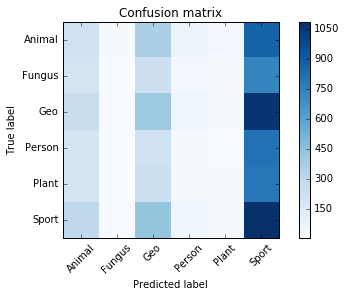

In [107]:
plt.figure()
plot_confusion_matrix(cm)

In [108]:
accuracy = (np.array(true_arr) == np.array(pred_arr)).sum() / float(len(true_arr))
print accuracy

0.19439189941


# SVD - Pearson Correlation Coefficient

In [109]:
corr_mat = np.ma.corrcoef(new_mat)
nn_arr = get_reverse_neighbours(corr_mat)
pred_arr = get_pred_arr(nn_arr)
cm = get_confusion_matrix(pred_arr)
print cm

[[ 910   72  270   48  133  138]
 [ 181  656  178   17  129   46]
 [ 104   53 1511   21   41   78]
 [ 239  118  324  404   50  107]
 [ 164  132  195   17  715   48]
 [ 265   68  459   49   94  953]]


In [77]:
accuracy = (np.array(true_arr) == np.array(pred_arr)).sum() / float(len(true_arr))
print accuracy

0.572938689218
